# Bike Sharing Demand

## Data Preparation

In [1]:
import pandas as pd

df = pd.read_csv('train.csv')
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


Separate the features and the label.

In [3]:
y = df['count']
X = df.drop(['casual', 'registered', 'count'], axis=1)

## Data Wrangling

It seems that *datetime* is represented merely as a string and requires some conversion.

In [4]:
X['datetime'] = X['datetime'].apply(pd.to_datetime)
X['year'] = X['datetime'].apply(lambda x: x.year)
X['month'] = X['datetime'].apply(lambda x: x.month)
X['day'] = X['datetime'].apply(lambda x: x.day)
X['hour'] = X['datetime'].apply(lambda x: x.hour)
X.drop('datetime', axis=1, inplace=True)

In addition, we will one-hot encode some categorical features.

In [8]:
X = pd.get_dummies(X, columns=['year', 'month', 'day', 'hour', 'holiday', 'workingday', 'season', 'weather'])

Now we will analyze the target distribution.

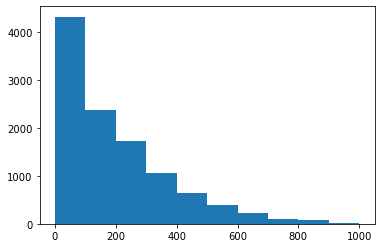

In [5]:
import matplotlib.pyplot as plt

plt.hist(y, bins=range(0, 1001, 100))
plt.xticks(range(0, 1001, 200))
plt.show()

The figure shows a skewed distribution. Let's log-scale the labels.

In [6]:
import numpy as np

y = y.apply(np.log1p)

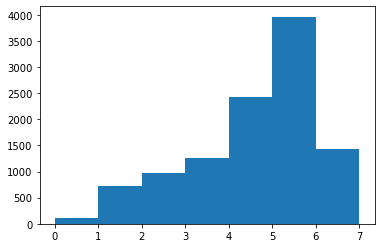

In [7]:
plt.hist(y, bins=range(0, 8))
plt.xticks(range(0, 8))
plt.show()

Split the dataset into train and test parts.

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Train Model

We are going to use LightGBM regressor.

In [10]:
from lightgbm import LGBMRegressor

lgbm_regressor = LGBMRegressor(n_estimators=500)

lgbm_regressor.fit(X_train, y_train)

LGBMRegressor(n_estimators=500)

## Test Model

In [14]:
from sklearn.metrics import mean_squared_log_error

pred = lgbm_regressor.predict(X_test)
pred_expm1 = np.expm1(pred)
y_test_expm1 = np.expm1(y_test)
msle = mean_squared_log_error(pred_expm1, y_test_expm1)
rmsle = msle**0.5
print(f'Root mean squared log error: {rmsle:.3f}')

Root mean squared log error: 0.318
